In [1]:
# from autocvd import autocvd
# autocvd(num_gpus = 1)

import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
import jax
jax.config.update('jax_platform_name', 'cpu') 

import pandas as pd
from chainconsumer import Chain, ChainConsumer, Truth
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from astropy import units as u
from odisseo.units import CodeUnits


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 

Parameter M_MN in chain Experimental Results is not constrained


Dataset shape: (550, 4)
Parameter names: ['M_MN', 'M_NFW', 'M_plummer', 't_end']

Mean values:
M_MN: 62909059576.5527
M_NFW: 470336081368.9018
M_plummer: 11123.2826
t_end: 3.1927

Standard deviations:
M_MN: 13021964969.6997
M_NFW: 55871355210.0893
M_plummer: 5605.1338
t_end: 0.2822


Parameter M_plummer in chain Experimental Results is not constrained


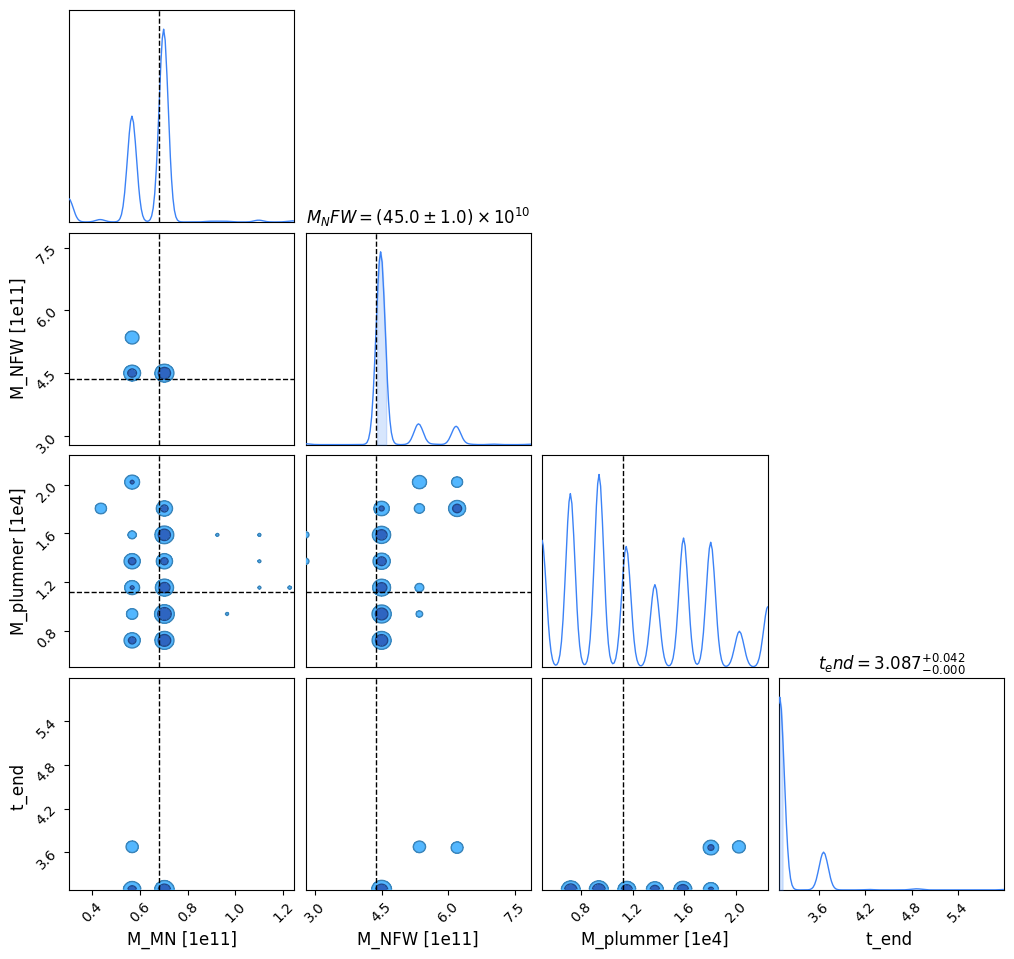

In [5]:
import numpy as np
import matplotlib.pyplot as plt 
import pickle
import os
import pandas as pd
from chainconsumer import Chain, ChainConsumer
from scipy.stats import multivariate_normal

# Load your data
files_dir = './sampling_target_error_resampling/'
files_path = [os.path.join(files_dir, f) for f in os.listdir(files_dir) if f.endswith('.pkl')]
data = [pickle.load(open(f, 'rb')) for f in files_path]
df = pd.DataFrame(data)
df = df.astype(float)

df = df[(df['t_end'] > 1/4 * params.t_end * code_units.code_time.to(u.Gyr)) & (df['t_end'] < 8/4 * params.t_end * code_units.code_time.to(u.Gyr))]  
df = df[df['M_NFW'] > 1/4 * params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)]  # Filter out M_NFW < 1/4 Mvir
df = df[df['M_NFW'] < 8/4 * params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)]  # Filter out M_NFW > 4 Mvir
df = df[df['M_MN'] > 1/4 * params.MN_params.M * code_units.code_mass.to(u.Msun)]  # Filter out M_MN < 1/4 MN
df = df[df['M_MN'] < 8/4 * params.MN_params.M * code_units.code_mass.to(u.Msun)]  # Filter out M_MN > 4 MN
df = df[df['M_plummer'] > 1/4 * params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun)]  # Filter out M_Plummer < 1/4 Plummer
df = df[df['M_plummer'] < 8/4 * params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun)]  # Filter out M_Plummer > 4 Plummer

# df = df[df['t_end'] < 13  ]  # Filter out t_end < 1.5 Gyr
# Convert to float and handle any non-numeric columns
numeric_df = df.select_dtypes(include=[np.number])
if numeric_df.empty:
    # If no numeric columns, convert all to float
    numeric_df = df.astype(float)

# Get statistics
mean_values = numeric_df.mean()
covariance_matrix = numeric_df.cov()
correlation_matrix = numeric_df.corr()

print("Dataset shape:", numeric_df.shape)
print("Parameter names:", list(numeric_df.columns))
print("\nMean values:")
for param, mean_val in mean_values.items():
    print(f"{param}: {mean_val:.4f}")

print("\nStandard deviations:")
for param, std_val in numeric_df.std().items():
    print(f"{param}: {std_val:.4f}")

# Create corner plot with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=numeric_df, name="Experimental Results", ), )
c.add_truth(Truth(location={
    't_end': params.t_end * code_units.code_time.to(u.Gyr), 
    'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
    'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
    'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),
}))
fig = c.plotter.plot()
plt.show()

Parameter M_MN in chain Original Data is not constrained
Parameter M_plummer in chain Original Data is not constrained


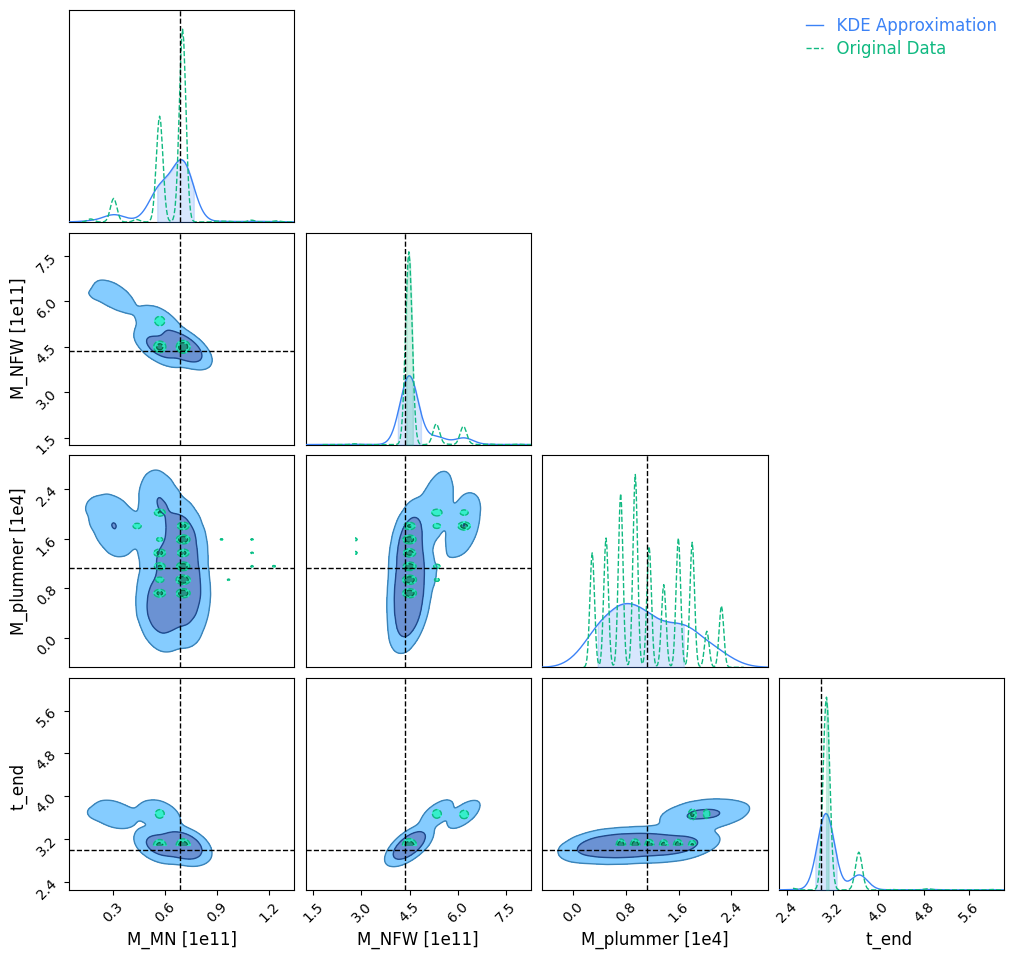

In [3]:
from scipy.stats import gaussian_kde
import numpy as np

def generate_kde_samples(df, n_samples=10000):
    """Generate samples from KDE of your data"""
    
    # Convert DataFrame to numpy array
    data_array = df.values.T  # Transpose for sklearn format
    
    # Create KDE
    kde = gaussian_kde(data_array, bw_method='silverman')  # 'scott' or 'silverman' for bandwidth selection
    
    # Generate new samples
    kde_samples = kde.resample(n_samples).T
    
    # Convert back to DataFrame
    kde_df = pd.DataFrame(kde_samples, columns=df.columns)
    
    return kde_df

# Generate KDE samples
kde_samples_df = generate_kde_samples(df, n_samples=500_000)

# Plot with ChainConsumer
c = ChainConsumer()
c.add_chain(Chain(samples=kde_samples_df, name="KDE Approximation"))
c.add_chain(Chain(samples=numeric_df, name="Original Data", linestyle="--"))
c.add_truth(Truth(location={
    't_end': params.t_end * code_units.code_time.to(u.Gyr), 
    'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
    'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
    'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),
}))

fig = c.plotter.plot()
plt.show()

Mean values:
M_MN         6.290906e+10
M_NFW        4.703361e+11
M_plummer    1.112328e+04
t_end        3.192743e+00
dtype: float64

Covariance matrix:
                   M_MN         M_NFW     M_plummer         t_end
M_MN       1.695716e+20 -4.912971e+20 -2.031374e+13 -1.585754e+09
M_NFW     -4.912971e+20  3.121608e+21  1.657766e+14  1.233514e+10
M_plummer -2.031374e+13  1.657766e+14  3.141753e+07  7.599281e+02
t_end     -1.585754e+09  1.233514e+10  7.599281e+02  7.964565e-02


Parameter M_MN in chain Original Data is not constrained
Parameter M_plummer in chain Original Data is not constrained


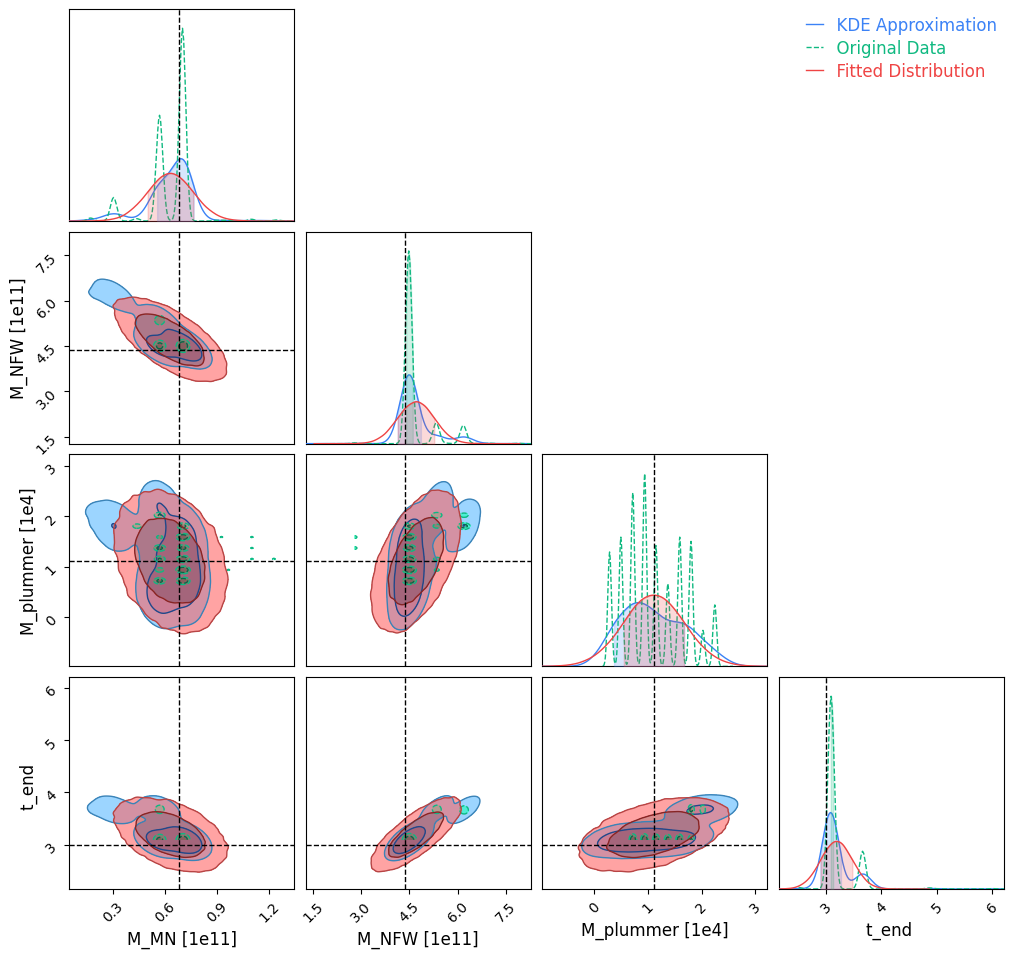

In [4]:
from scipy.stats import multivariate_normal

# Get mean and covariance from your DataFrame
mean_values = df.mean()
covariance_matrix = df.cov()

print("Mean values:")
print(mean_values)
print("\nCovariance matrix:")
print(covariance_matrix)

# Convert to numpy arrays if needed
mean_array = mean_values.values
cov_array = covariance_matrix.values

# Generate samples from the multivariate normal distribution
n_samples = 100_000
mean_array = mean_values.values
cov_array = covariance_matrix.values

# Generate new samples
generated_samples = multivariate_normal.rvs(
    mean=mean_array, 
    cov=cov_array, 
    size=n_samples
)

# Convert back to DataFrame with original column names
generated_df = pd.DataFrame(generated_samples, columns=numeric_df.columns)

# Plot both original data and generated samples
c = ChainConsumer()
c.add_chain(Chain(samples=kde_samples_df, name="KDE Approximation"))
c.add_chain(Chain(samples=numeric_df, name="Original Data", linestyle="--"))
c.add_truth(Truth(location={'t_end': params.t_end * code_units.code_time.to(u.Gyr), 
                           'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                           'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
                           'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),}))
c.add_chain(Chain(samples=generated_df, name="Fitted Distribution"))

fig = c.plotter.plot()
plt.show()